<a href="https://colab.research.google.com/github/simecek/dspracticum2020/blob/master/lecture_02/01_one_neuron_and_MPG_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.0


## Data

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()

# because of missing values in the Horsepower column
dataset = dataset.dropna()

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [3]:
# split the dataset into two parts (train & test)
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

train_dataset.shape, test_dataset.shape

((314, 8), (78, 8))

In [4]:
# separate label column from the data
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((314, 7), (78, 7), (314,), (78,))

## Predict MPG (miles per gallon) from Horsepower

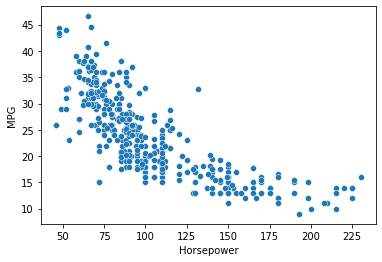

In [5]:
sns.scatterplot(data=dataset, x="Horsepower", y="MPG");

In [6]:
horsepower = np.array(train_features['Horsepower'])

# we will use train data to estimate average and SD of horsepower and
# get transformation to zero mean and unit variance
horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

normalized_horsepower = np.array(horsepower_normalizer(horsepower))
normalized_horsepower.mean(), normalized_horsepower.std()

(3.0371794e-08, 1.0)

In [13]:
# model

horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [14]:
# model compilation
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [15]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

print(history.history['val_loss'][-1:])

[3.316584587097168]
CPU times: user 2 s, sys: 104 ms, total: 2.11 s
Wall time: 1.86 s


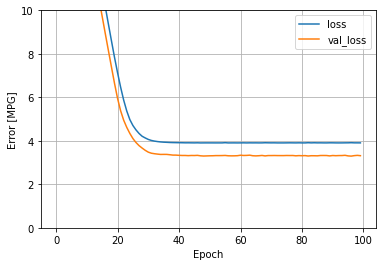

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

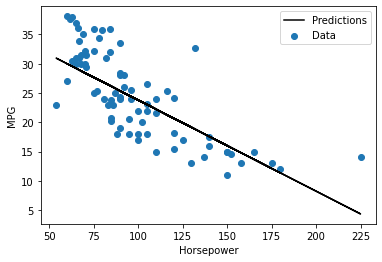

In [17]:
# prediction on test data
test_data_predictions = horsepower_model.predict(test_features['Horsepower'])

def plot_horsepower(preds):
  plt.scatter(test_features['Horsepower'], test_labels, label='Data')
  plt.plot(test_features['Horsepower'], preds, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(test_data_predictions)

In [18]:
# evaluation on test data
test_evaluation = {}
test_evaluation['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)
test_evaluation

{'horsepower_model': 3.9421019554138184}

## Predict MPG (miles per gallon) from Other Features

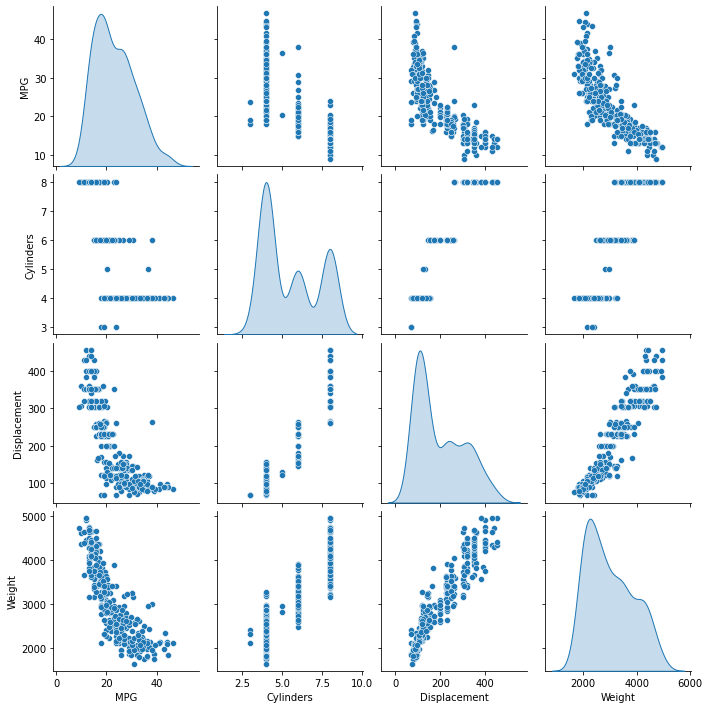

In [19]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde');

In [20]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.153822,7.861854,9.0,17.000,22.0,28.075,46.6
Cylinders,314.0,5.531847,1.729449,3.0,4.000,4.0,8.000,8.0
Displacement,314.0,197.855096,106.501896,68.0,105.000,151.0,302.000,455.0
Horsepower,314.0,105.971338,39.636557,46.0,76.000,95.0,130.000,230.0
Weight,314.0,3005.745223,859.060925,1649.0,2231.000,2831.5,3641.750,4955.0
Acceleration,314.0,15.510828,2.803560,8.0,13.625,15.5,17.000,24.8
Model Year,314.0,75.910828,3.688989,70.0,73.000,76.0,79.000,82.0
Origin,314.0,1.579618,0.808322,1.0,1.000,1.0,2.000,3.0


In [21]:
# normalizer for all feature columns
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [22]:
# model definition
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [23]:
# you can even do prediction from (untrained) model or look what is his weights
print(linear_model.predict(train_features[:10]))

# parameters (weights and bias)
linear_model.layers[1].kernel, linear_model.layers[1].bias

[[ 0.90721786]
 [-0.4084107 ]
 [-0.2760517 ]
 [ 1.997714  ]
 [ 0.7164786 ]
 [-0.44676822]
 [-0.8459356 ]
 [-0.5471232 ]
 [ 0.6581513 ]
 [ 1.2042629 ]]


(<tf.Variable 'dense_2/kernel:0' shape=(7, 1) dtype=float32, numpy=
 array([[-0.35590607],
        [ 0.11128467],
        [-0.6101192 ],
        [-0.23704726],
        [ 0.00969779],
        [-0.28061503],
        [-0.77606255]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>)

In [24]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [25]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.08 s, sys: 102 ms, total: 2.18 s
Wall time: 1.91 s


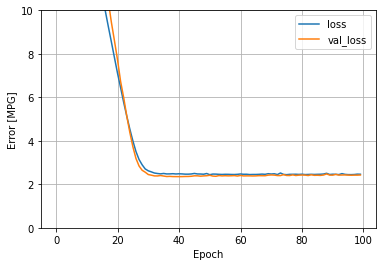

In [26]:
plot_loss(history)